In [1]:
import pandas as pd
import numpy as np
import folium 
from IPython.display import HTML, display
import seaborn as sns
sns.set_style('whitegrid')
from matplotlib import pyplot as plt
%matplotlib inline
from datetime import datetime, timedelta
import math
from math import radians, cos, sin, asin, sqrt
from folium import plugins


In [2]:
df_raw = pd.read_csv('./analyze_me.csv') #loading the data into a pandas dataframe
df_raw.info() #preliminary information about the data, dataypes
df_raw.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5983 entries, 0 to 5982
Data columns (total 18 columns):
delivery_id                            5983 non-null int64
customer_id                            5983 non-null int64
jumpman_id                             5983 non-null int64
vehicle_type                           5983 non-null object
pickup_place                           5983 non-null object
place_category                         5100 non-null object
item_name                              4753 non-null object
item_quantity                          4753 non-null float64
item_category_name                     4753 non-null object
how_long_it_took_to_order              3038 non-null object
pickup_lat                             5983 non-null float64
pickup_lon                             5983 non-null float64
dropoff_lat                            5983 non-null float64
dropoff_lon                            5983 non-null float64
when_the_delivery_started              5983 non-nul

,delivery_id,customer_id,jumpman_id,vehicle_type,pickup_place,place_category,item_name,item_quantity,item_category_name,how_long_it_took_to_order,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon,when_the_delivery_started,when_the_Jumpman_arrived_at_pickup,when_the_Jumpman_left_pickup,when_the_Jumpman_arrived_at_dropoff
0,1457973,327168,162381,van,Melt Shop,American,Lemonade,1.0,Beverages,00:19:58.582052,40.744607,-73.990742,40.752073,-73.985370,2014-10-26 13:51:59.898924,NaN,NaN,2014-10-26 14:52:06.313088
1,1377056,64452,104533,bicycle,Prince Street Pizza,Pizza,Neapolitan Rice Balls,3.0,Munchables,00:25:09.107093,40.723080,-73.994615,40.719722,-73.991858,2014-10-16 21:58:58.65491,2014-10-16 22:26:02.120931,2014-10-16 22:48:23.091253,2014-10-16 22:59:22.948873
2,1476547,83095,132725,bicycle,Bareburger,Burger,Bare Sodas,1.0,Drinks,00:06:44.541717,40.728478,-73.998392,40.728606,-73.995143,2014-10-28 21:39:52.654394,2014-10-28 21:37:18.793405,2014-10-28 21:59:09.98481,2014-10-28 22:04:40.634962
3,1485494,271149,157175,bicycle,Juice Press,Juice Bar,OMG! My Favorite Juice!,1.0,Cold Pressed Juices,NaN,40.738868,-74.002747,40.751257,-74.005634,2014-10-30 10:54:11.531894,2014-10-30 11:04:17.759577,2014-10-30 11:16:37.895816,2014-10-30 11:32:38.090061
4,1327707,122609,118095,bicycle,Blue Ribbon Sushi,Japanese,Spicy Tuna & Tempura Flakes,2.0,Maki (Special Rolls),00:03:45.035418,40.726110,-74.002492,40.709323,-74.015867,2014-10-10 00:07:18.450505,2014-10-10 00:14:42.702223,2014-10-10 00:25:19.400294,2014-10-10 00:48:27.150595


In [3]:
df_raw.isnull().sum() #check for Nan in the data

delivery_id                               0
customer_id                               0
jumpman_id                                0
vehicle_type                              0
pickup_place                              0
place_category                          883
item_name                              1230
item_quantity                          1230
item_category_name                     1230
how_long_it_took_to_order              2945
pickup_lat                                0
pickup_lon                                0
dropoff_lat                               0
dropoff_lon                               0
when_the_delivery_started                 0
when_the_Jumpman_arrived_at_pickup      550
when_the_Jumpman_left_pickup            550
when_the_Jumpman_arrived_at_dropoff       0
dtype: int64

We have quite a few null values in item_name, item_quantity, item_category_name which could possibly indicate missing menu items. There are also null values in timestamps related to the pick up place which needs to be explored since this gives the effective delivery time.

In [4]:
print df_raw['delivery_id'].nunique() #check for duplicates
print df_raw.shape

5214
(5983, 18)


 There are a total of 5983 entries for deliveries out of which only 5214 are unique. So from the data looks like if the delivery has more than one item-category there are multiple records corresponding to that so dropping duplicates on delivery_id will give us a better idea about time.

In [5]:
df = df_raw.drop_duplicates('delivery_id')  #drop duplicate rows
df.shape

(5214, 18)

For service time and other time related analysis, let's first start with this data.

In [10]:

#convert to datetime for easier  manipulation
df['when_the_Jumpman_arrived_at_pickup'] = pd.to_datetime(pd.to_datetime(df['when_the_Jumpman_arrived_at_pickup']).apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S')if not pd.isnull(x) else ''))
df['when_the_delivery_started'] = pd.to_datetime(pd.to_datetime(df['when_the_delivery_started']).apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S')if not pd.isnull(x) else ''))
df['when_the_Jumpman_left_pickup'] = pd.to_datetime(pd.to_datetime(df['when_the_Jumpman_left_pickup']).apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S')if not pd.isnull(x) else ''))
df['when_the_Jumpman_arrived_at_dropoff'] = pd.to_datetime(pd.to_datetime(df['when_the_Jumpman_arrived_at_dropoff']).apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S')if not pd.isnull(x) else ''))


/Users/anushag/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/anushag/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/anushag/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http:/

In [11]:
def convert_to_min(times):
    if pd.isnull(times) :
        return 0
    else:
        return (times).total_seconds()/60

In [12]:
# calculate some intervals
df['service_time'] = (df['when_the_Jumpman_arrived_at_dropoff']-df['when_the_delivery_started']).apply(convert_to_min)
df['travel_time'] = (df['when_the_Jumpman_arrived_at_dropoff']- df['when_the_Jumpman_left_pickup']).apply(convert_to_min)
df['jumpman_arrival_after_delivery_started'] = (df['when_the_Jumpman_arrived_at_pickup'] - df['when_the_delivery_started']).apply(convert_to_min)
df['wait_at_pickup'] = (df['when_the_Jumpman_left_pickup'] - df['when_the_Jumpman_arrived_at_pickup']).apply(convert_to_min)

/Users/anushag/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/anushag/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/anushag/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

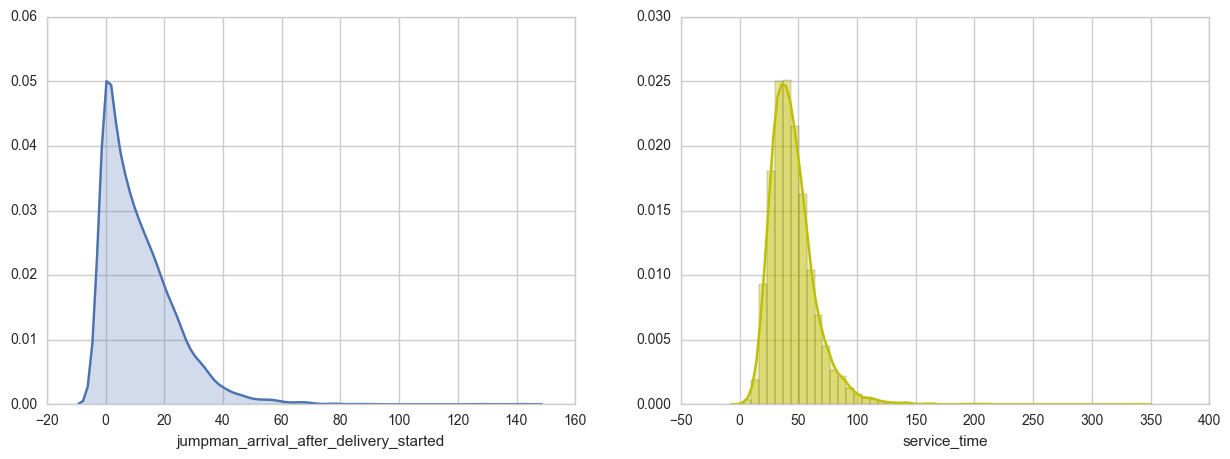

In [13]:
fig , (axis1,axis2) = plt.subplots(1,2,figsize=(15,5))
sns.distplot(df['jumpman_arrival_after_delivery_started'], ax=axis1,kde_kws={"shade": True},hist=False)
sns.distplot(df['service_time'], color='y', kde_kws={"shade": True} , ax=axis2)

There are some negative values for this time difference which is actually how much time after the delivery was started did the jumpan arrive at the pickup location. A negative value indicates that the jumpman was present at the pick up place even before the delivery started. This could be a potential data integrity issue. There is a spike at '0' because I substituted 0 for null values. So, basically lot of data is just missing.

The average service time seems to be about 45 minutes.

Let's see a quick distribution of the time of the day and how orderes change.

In [14]:
def time_slice(hour):
    if hour <= 6:
        return 'night'
    elif hour <= 12:
        return 'morning'
    elif hour <= 18:
        return 'afternoon'
    elif hour <= 23:
        return 'evening'

In [15]:
df['food_time'] = df['when_the_delivery_started'].apply(lambda x: x.hour)
df['food_time'] = df.food_time.apply(time_slice)

/Users/anushag/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/anushag/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


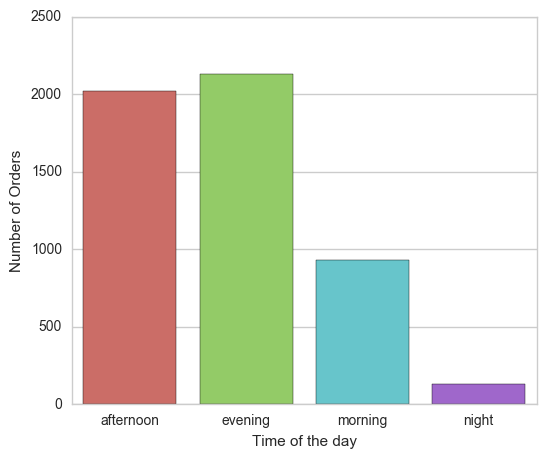

In [16]:
fig , (axis1) = plt.subplots(1,1,figsize=(6,5))
sns.countplot(x='food_time',data=df, palette='hls', ax=axis1)
axis1.set(ylabel = 'Number of Orders')
axis1.set(xlabel = 'Time of the day')

Evening, that between 6pm and 11pm sees the maximum number of orders. It is important that the service time during these hours is short in order to get more customers.

Let's see how the service time varies during different times of the day.

(10, 100)

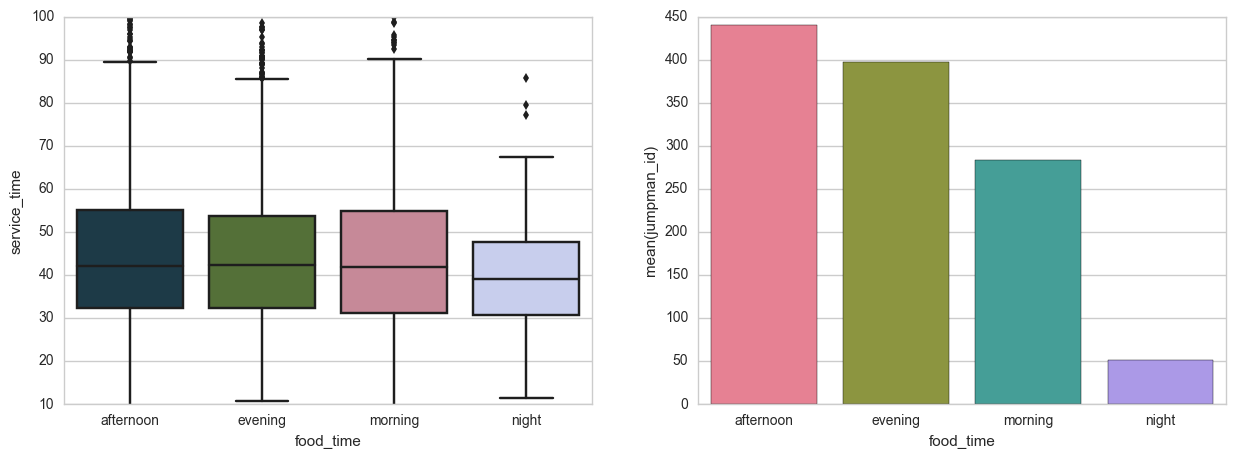

In [17]:
#df[['food_time', 'service_time']]

avg = df.groupby('food_time')['service_time'].mean().reset_index()
nj =  df.groupby('food_time')['jumpman_id'].nunique().reset_index()

fig , (axis1, axis2) = plt.subplots(1,2,figsize=(15,5))
sns.boxplot(x='food_time', y='service_time', data=df, ax=axis1, palette='cubehelix')
sns.barplot(x='food_time', y='jumpman_id', data=nj, ax=axis2, palette='husl')
axis1.set_ylim([10,100])


The mean service time for all times of the day seems to be similar. As we see that maximum number of orders come in during the afternoon and evening , it would be best to reduce the service time during these times by allocating more jumpen. Here is a distribution of number of jumpman foreach time of the day. Increasing the for evening may help.

Let's map the location during these times of the day for pickup and drop off.

In [31]:
disloc = df.sort('distance',ascending=False)[['distance','food_time','pickup_lat','pickup_lon','dropoff_lat', 'dropoff_lon']][0:125]

/Users/anushag/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [33]:
NYC_COORDINATES = (40.71, -74.1)
MAX_RECORDS=300
mmap = folium.Map(location=NYC_COORDINATES, zoom_start=12, min_lon=-74.05)
for each in disloc[0:MAX_RECORDS].iterrows():
    folium.Marker(location = [each[1]['pickup_lat'],each[1]['pickup_lon']],icon = folium.Icon(color ='green')).add_to(mmap)
    folium.Marker(location = [each[1]['dropoff_lat'],each[1]['dropoff_lon']]).add_to(mmap)
mmap

heatmaps for Morning, afternoon and evening for pick up and dropoff locations.

In [20]:
morning_loc = df[df['food_time'].apply(lambda x : x is 'morning')][['food_time','pickup_lat','pickup_lon','dropoff_lat', 'dropoff_lon']]
aft_loc = df[df['food_time'].apply(lambda x : x is 'afternoon')][['food_time','pickup_lat','pickup_lon','dropoff_lat', 'dropoff_lon']]
evening_loc = df[df['food_time'].apply(lambda x : x is 'evening')][['food_time','pickup_lat','pickup_lon','dropoff_lat', 'dropoff_lon']]


In [21]:

mmap1 = folium.Map(location=NYC_COORDINATES,  zoom_start=12, min_lat=40.64, min_lon=-74.05)
mmap1.add_children(plugins.HeatMap(zip(morning_loc['pickup_lat'],morning_loc['pickup_lon']), radius=20))
mmap2 = folium.Map(location=NYC_COORDINATES, zoom_start=12, min_lat=40.64, min_lon=-74.05)
mmap2.add_children(plugins.HeatMap(zip(morning_loc['dropoff_lat'],morning_loc['dropoff_lon']), radius=20))
mmap1.save('mp.html')
mmap2.save('md.html')
display(HTML("<iframe src='mp.html' width=475 height=800></iframe><iframe src='md.html' width=475 height=800></iframe>"))


In [22]:
mmap1 = folium.Map(location=NYC_COORDINATES,  zoom_start=12, min_lat=40.64, min_lon=-74.05)
mmap1.add_children(plugins.HeatMap(zip(aft_loc['pickup_lat'],aft_loc['pickup_lon']), radius=20))
mmap2 = folium.Map(location=NYC_COORDINATES,  zoom_start=12,min_lat= 40.64,min_lon=-74.05)
mmap2.add_children(plugins.HeatMap(zip(aft_loc['dropoff_lat'],aft_loc['dropoff_lon']), radius=20))
mmap1.save('ap.html')
mmap2.save('ad.html')
display(HTML("<iframe src='ap.html' width=475 height=800></iframe><iframe src='ad.html' width=475 height=800></iframe>"))


In [23]:
mmap1 = folium.Map(location=NYC_COORDINATES,  zoom_start=12,min_lat=40.65, min_lon=-74.05)
mmap1.add_children(plugins.HeatMap(zip(evening_loc['pickup_lat'],evening_loc['pickup_lon']), radius=20))
mmap2 = folium.Map(location=NYC_COORDINATES,  zoom_start=12, min_lat=40.65, min_lon=-74.05)
mmap2.add_children(plugins.HeatMap(zip(evening_loc['dropoff_lat'],evening_loc['dropoff_lon']), radius=20))
mmap1.save('ep.html')
mmap2.save('ed.html')
display(HTML("<iframe src='ep.html' width=475 height=800></iframe><iframe src='ed.html' width=475 height=800></iframe>"))


In [24]:
def distdp(lat1, lat2, lon1, lon2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km * 0.621371

In [25]:
df['distance'] = distdp(df['dropoff_lat'],df['pickup_lat'],df['dropoff_lon'],df['pickup_lon'])

/Users/anushag/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


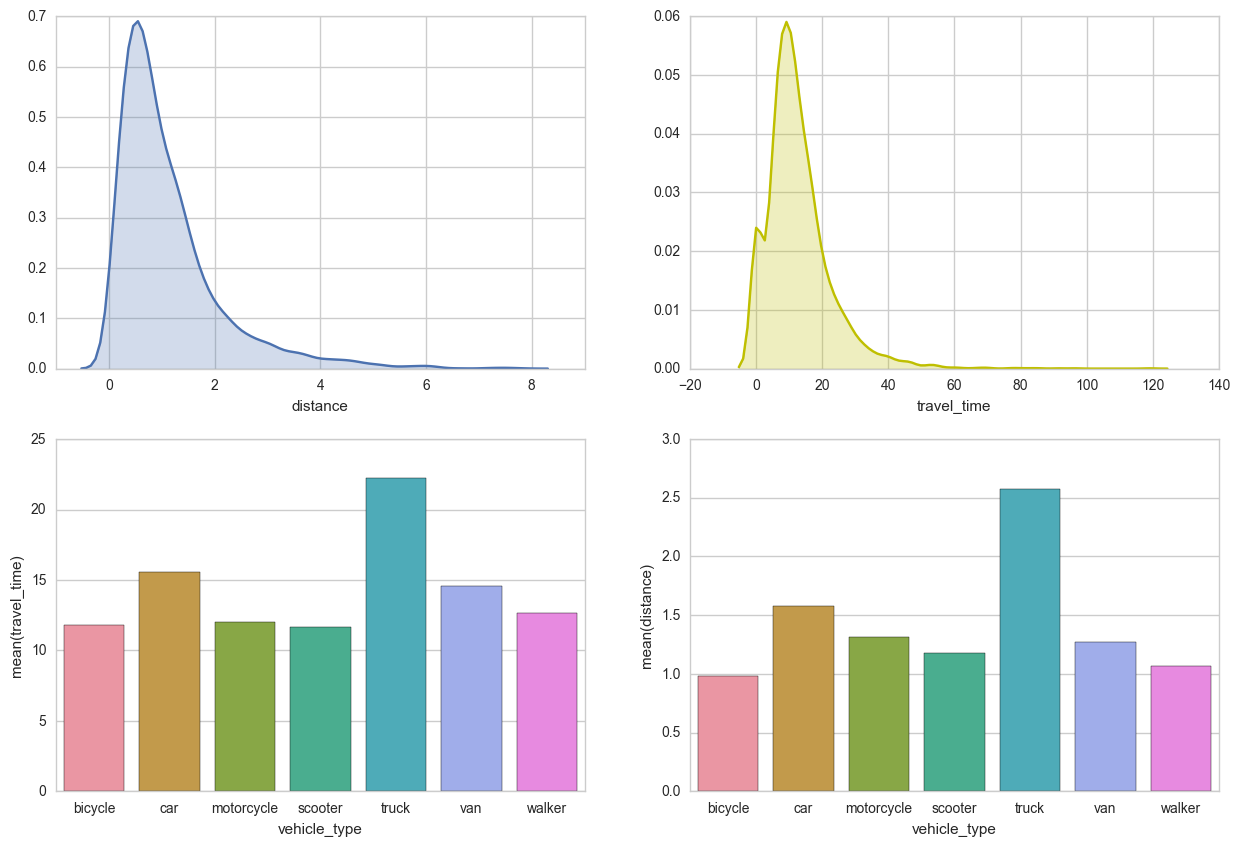

In [26]:
fig , ((axis1,axis2),(axis3,axis4)) = plt.subplots(2,2,figsize=(15,10))
sns.distplot(df['distance'], ax=axis1,kde_kws={"shade": True},hist=False)
sns.distplot(df['travel_time'], color='y', kde_kws={"shade": True} ,hist=False, ax=axis2)

vtt = df.groupby('vehicle_type')['travel_time'].mean().reset_index()
sns.barplot(x='vehicle_type',y='travel_time' ,data=vtt, ax=axis3)

vd = df.groupby('vehicle_type')['distance'].mean().reset_index()
sns.barplot(x='vehicle_type',y='distance' ,data=vd, ax=axis4)



new customer vs returning customer

In [27]:
df['customer_id'].nunique()


3192

About 2022 returning customers in a month and  3192 new customers in a month. User growth rate.

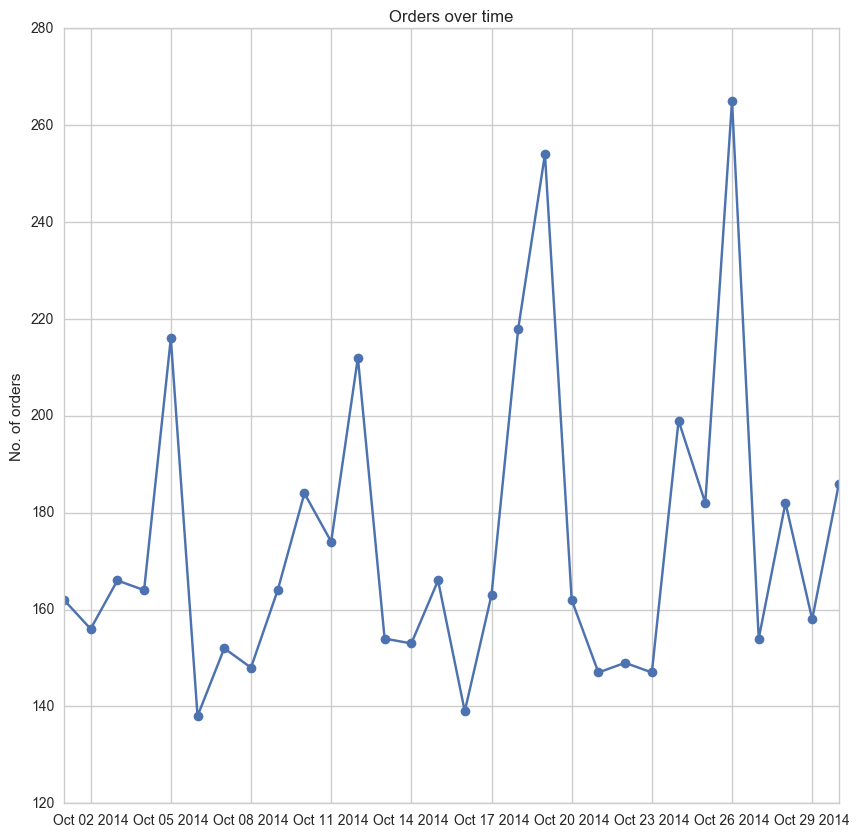

In [28]:
time = df.groupby('when_the_delivery_started')['delivery_id'].count().reset_index()
data2 = time.set_index('when_the_delivery_started')
data2 = data2.groupby([pd.TimeGrouper('D')]).sum()
plt.figure(figsize=(10.,10))
plt.plot(data2, marker='o',)
plt.ylabel('No. of orders')
plt.title('Orders over time')

In [29]:
df_new_cust = df.drop_duplicates('customer_id')

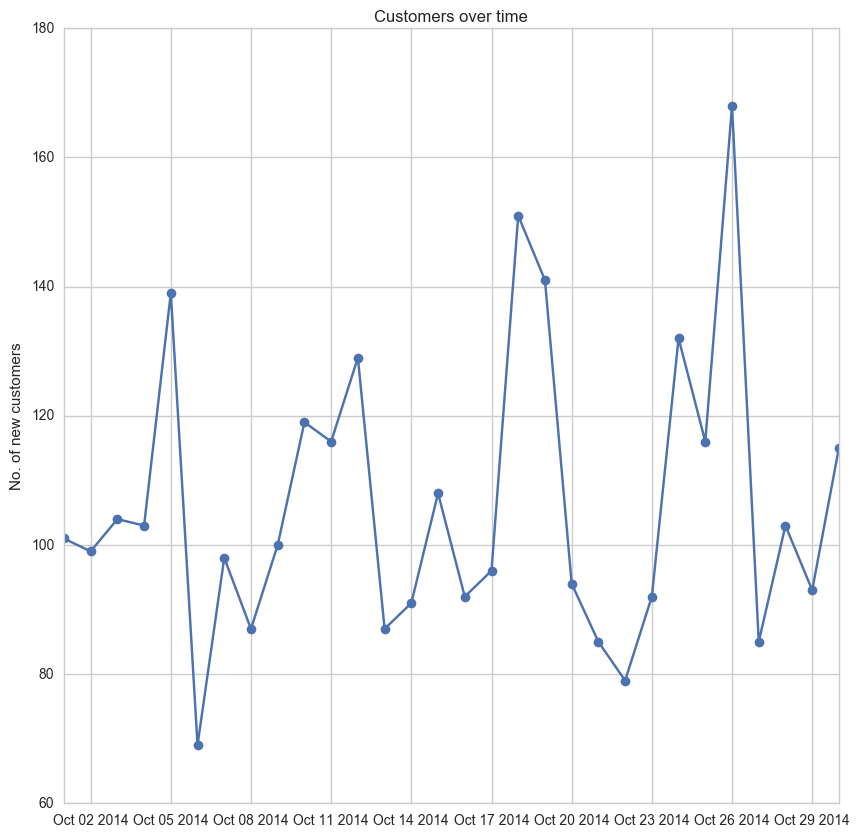

In [30]:
time = df_new_cust.groupby('when_the_delivery_started')['customer_id'].count().reset_index()
data2 = time.set_index('when_the_delivery_started')
data2 = data2.groupby([pd.TimeGrouper('D')]).sum()
plt.figure(figsize=(10.,10))
plt.plot(data2, marker='o',)
plt.ylabel('No. of new customers')
plt.title('Customers over time')

maximum orders on weekend. sundays. as expected. showing the trend in october as to how the orders have been